In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

from keras.layers import BatchNormalization, Dropout, Dense, Input
from keras.models import Model
from keras.optimizers import Adam, Nadam, RMSprop
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.utils import to_categorical
import umap

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, cohen_kappa_score, matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split

c:\Users\misha\anaconda3\envs\tfgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_true = np.argmax(y, axis = 1)
    
    # Get accuracy, precision, recall, f1-score
    print("Classification Report:")
    print(classification_report(y_true, np.argmax(y_pred, axis = 1)))

    # Get confusion matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis = 1))
    plt.figure(figsize = (8, 6))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', 
                xticklabels = ['Fake signature', 'True signature'], 
                yticklabels = ['Fake signature', 'True signature'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
    plt.plot(fpr, tpr)
    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), c = 'r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred[:, 1])
    plt.plot(recall, precision)
    plt.plot([0, 1], [1, 0], c = 'r')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    print("ROC-AUC Score:", roc_auc_score(y_true, y_pred[:, 1]))
    print("Kappa:", cohen_kappa_score(y_true, np.argmax(y_pred, axis = 1)))
    print("MCC:", matthews_corrcoef(y_true, np.argmax(y_pred, axis = 1)))

In [3]:
df = pd.read_csv("Supplementary_Table_2.csv")

In [3]:
df.head()

,Genome,sRNA Accession,sRNA,Target Accession,Target,Length of sRNA sequence,Length of Target coding region,Upstream gene (same strand) overlaps target start codon,Distance to upstream gene (same strand) from target start codon,Upstream gene (either strand) overlaps target start codon,...,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,TargetRNA3: probability,Evinced Interaction
0,Escherichia coli str. K-12 substr. MG1655,NC_000913.3,ryhB,NC_000913.3,thrL,95,66,1,190,1,...,0.013638,-0.021805,-0.003784,0.013937,0.013338,-0.000300,-0.018021,-0.057847,0.186263,0
1,Escherichia coli str. K-12 substr. MG1655,NC_000913.3,ryhB,NC_000913.3,thrA,95,2463,1,81,1,...,0.002670,-0.008768,-0.000686,0.006711,-0.008083,0.002670,-0.014794,-0.045067,0.444211,0
2,Escherichia coli str. K-12 substr. MG1655,NC_000913.3,ryhB,NC_000913.3,thrB,95,933,1,1,1,...,0.022804,0.008010,0.019449,0.013423,-0.004727,-0.000686,-0.001371,-0.065202,0.340565,1
3,Escherichia coli str. K-12 substr. MG1655,NC_000913.3,ryhB,NC_000913.3,thrC,95,1287,1,0,1,...,-0.000686,-0.018835,0.006026,0.016779,-0.021505,-0.000686,0.001985,-0.048423,0.455614,0
4,Escherichia coli str. K-12 substr. MG1655,NC_000913.3,ryhB,NC_000913.3,yaaX,95,297,1,213,1,...,0.002670,-0.012124,0.002670,0.003356,0.001985,0.002670,-0.014794,-0.048423,0.340439,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329548 entries, 0 to 329547
Columns: 118 entries, Genome to Evinced Interaction
dtypes: float64(76), int64(37), object(5)
memory usage: 296.7+ MB


In [7]:
df.duplicated().sum()

0

In [12]:
df.isna().sum().sum()

0

In [4]:
df = df.drop(['Genome', "sRNA Accession", "sRNA", "Target Accession", "Target"], axis = 1)
df.head()

,Length of sRNA sequence,Length of Target coding region,Upstream gene (same strand) overlaps target start codon,Distance to upstream gene (same strand) from target start codon,Upstream gene (either strand) overlaps target start codon,Distance to upstream gene (either strand) from target start codon,Number of sRNA homologs (ALL),Number of target homologs (ALL),Are there sRNA:target homologs (ALL)?,Number of sRNA:target homologs (ALL),...,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,TargetRNA3: probability,Evinced Interaction
0,95,66,1,190,1,190,100,2,1,2,...,0.013638,-0.021805,-0.003784,0.013937,0.013338,-0.000300,-0.018021,-0.057847,0.186263,0
1,95,2463,1,81,1,81,100,100,1,75,...,0.002670,-0.008768,-0.000686,0.006711,-0.008083,0.002670,-0.014794,-0.045067,0.444211,0
2,95,933,1,1,1,1,100,96,1,76,...,0.022804,0.008010,0.019449,0.013423,-0.004727,-0.000686,-0.001371,-0.065202,0.340565,1
3,95,1287,1,0,1,0,100,99,1,71,...,-0.000686,-0.018835,0.006026,0.016779,-0.021505,-0.000686,0.001985,-0.048423,0.455614,0
4,95,297,1,213,1,213,100,62,1,58,...,0.002670,-0.012124,0.002670,0.003356,0.001985,0.002670,-0.014794,-0.048423,0.340439,0


In [14]:
for i in df.columns:
    print(i, "\n")

Length of sRNA sequence 

Length of Target coding region 

Upstream gene (same strand) overlaps target start codon 

Distance to upstream gene (same strand) from target start codon 

Upstream gene (either strand) overlaps target start codon 

Distance to upstream gene (either strand) from target start codon 

Number of sRNA homologs (ALL) 

Number of target homologs (ALL) 

Are there sRNA:target homologs (ALL)? 

Number of sRNA:target homologs (ALL) 

Number of sRNA homologs (16S relatives) 

Number of target homologs (16S relatives) 

Are there sRNA:target homologs (16S relatives)? 

Number of sRNA:target homologs (16S relatives) 

Seed of length 7 bps 

Seed of length 8 bps 

Seed of length 9 bps 

Seed of length 10 bps 

IntaRNA: is interaction found? 

IntaRNA: energy 

IntaRNA: length of sRNA interacting region 

IntaRNA: length of target interacting region 

IntaRNA: is interaction upstream of start codon? 

IntaRNA: distance of interaction from start codon 

IntaRNA: number of A

In [5]:
df = df.drop(['TargetRNA3: probability', "sRNARFTarget: probability", "RNAplex: energy considering accessibility",
              "RNAplex: energy not considering accessibility", "RNAup: total binding energy", "RNAup: interaction energy",
              "RNAup: target accessibility energy", "RNAup: sRNA accessibility energy", "CopraRNA: false-discovery-rate",
              "CopraRNA: p-value", "IntaRNA: length of largest bulge loop", "IntaRNA: number of bulge loops", 
              "IntaRNA: total length of bulge loops", "IntaRNA: length of largest interior loop",
              "IntaRNA: number of interior loops", "IntaRNA: total length of interior loops", "IntaRNA: length of largest canonical stacking region",
              "IntaRNA: length of largest stacking region", "IntaRNA: number of stacking regions", "IntaRNA: total number of bps",
              "IntaRNA: number of GU basepairs", "IntaRNA: number of GC bps", "IntaRNA: number of AU bps", "IntaRNA: distance of interaction from start codon",
              "IntaRNA: is interaction upstream of start codon?", "IntaRNA: length of target interacting region", "IntaRNA: length of sRNA interacting region",
              "IntaRNA: energy", "IntaRNA: is interaction found?"], axis = 1)

df.head()

,Length of sRNA sequence,Length of Target coding region,Upstream gene (same strand) overlaps target start codon,Distance to upstream gene (same strand) from target start codon,Upstream gene (either strand) overlaps target start codon,Distance to upstream gene (either strand) from target start codon,Number of sRNA homologs (ALL),Number of target homologs (ALL),Are there sRNA:target homologs (ALL)?,Number of sRNA:target homologs (ALL),...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,Evinced Interaction
0,95,66,1,190,1,190,100,2,1,2,...,0.017422,0.013638,-0.021805,-0.003784,0.013937,0.013338,-0.000300,-0.018021,-0.057847,0
1,95,2463,1,81,1,81,100,100,1,75,...,0.006711,0.002670,-0.008768,-0.000686,0.006711,-0.008083,0.002670,-0.014794,-0.045067,0
2,95,933,1,1,1,1,100,96,1,76,...,0.016779,0.022804,0.008010,0.019449,0.013423,-0.004727,-0.000686,-0.001371,-0.065202,1
3,95,1287,1,0,1,0,100,99,1,71,...,0.013423,-0.000686,-0.018835,0.006026,0.016779,-0.021505,-0.000686,0.001985,-0.048423,0
4,95,297,1,213,1,213,100,62,1,58,...,0.020134,0.002670,-0.012124,0.002670,0.003356,0.001985,0.002670,-0.014794,-0.048423,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329548 entries, 0 to 329547
Data columns (total 84 columns):
 #   Column                                                             Non-Null Count   Dtype  
---  ------                                                             --------------   -----  
 0   Length of sRNA sequence                                            329548 non-null  int64  
 1   Length of Target coding region                                     329548 non-null  int64  
 2   Upstream gene (same strand) overlaps target start codon            329548 non-null  int64  
 3   Distance to upstream gene (same strand) from target start codon    329548 non-null  int64  
 4   Upstream gene (either strand) overlaps target start codon          329548 non-null  int64  
 5   Distance to upstream gene (either strand) from target start codon  329548 non-null  int64  
 6   Number of sRNA homologs (ALL)                                      329548 non-null  int64  
 7   Number of t

In [6]:
new_column_names = {
    'Length of sRNA sequence': 'sRNA_seq_len',
    'Length of Target coding region': 'Target_coding_len',
    'Upstream gene (same strand) overlaps target start codon': 'Upstream_gene_same_overlap',
    'Distance to upstream gene (same strand) from target start codon': 'Dist_to_upstream_gene_same',
    'Upstream gene (either strand) overlaps target start codon': 'Upstream_gene_either_overlap',
    'Distance to upstream gene (either strand) from target start codon': 'Dist_to_upstream_gene_either',
    'Number of sRNA homologs (ALL)': 'Num_sRNA_homologs_ALL',
    'Number of target homologs (ALL)': 'Num_target_homologs_ALL',
    'Are there sRNA:target homologs (ALL)?': 'sRNA_target_homologs_ALL',
    'Number of sRNA:target homologs (ALL)': 'Num_sRNA_target_homologs_ALL',
    'Number of sRNA homologs (16S relatives)': 'Num_sRNA_homologs_16S',
    'Number of target homologs (16S relatives)': 'Num_target_homologs_16S',
    'Are there sRNA:target homologs (16S relatives)?': 'sRNA_target_homologs_16S',
    'Number of sRNA:target homologs (16S relatives)': 'Num_sRNA_target_homologs_16S'
}

df.rename(columns = new_column_names, inplace = True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329548 entries, 0 to 329547
Data columns (total 84 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   sRNA_seq_len                        329548 non-null  int64  
 1   Target_coding_len                   329548 non-null  int64  
 2   Upstream_gene_same_overlap          329548 non-null  int64  
 3   Dist_to_upstream_gene_same          329548 non-null  int64  
 4   Upstream_gene_either_overlap        329548 non-null  int64  
 5   Dist_to_upstream_gene_either        329548 non-null  int64  
 6   Num_sRNA_homologs_ALL               329548 non-null  int64  
 7   Num_target_homologs_ALL             329548 non-null  int64  
 8   sRNA_target_homologs_ALL            329548 non-null  int64  
 9   Num_sRNA_target_homologs_ALL        329548 non-null  int64  
 10  Num_sRNA_homologs_16S               329548 non-null  int64  
 11  Num_target_homologs_16S   

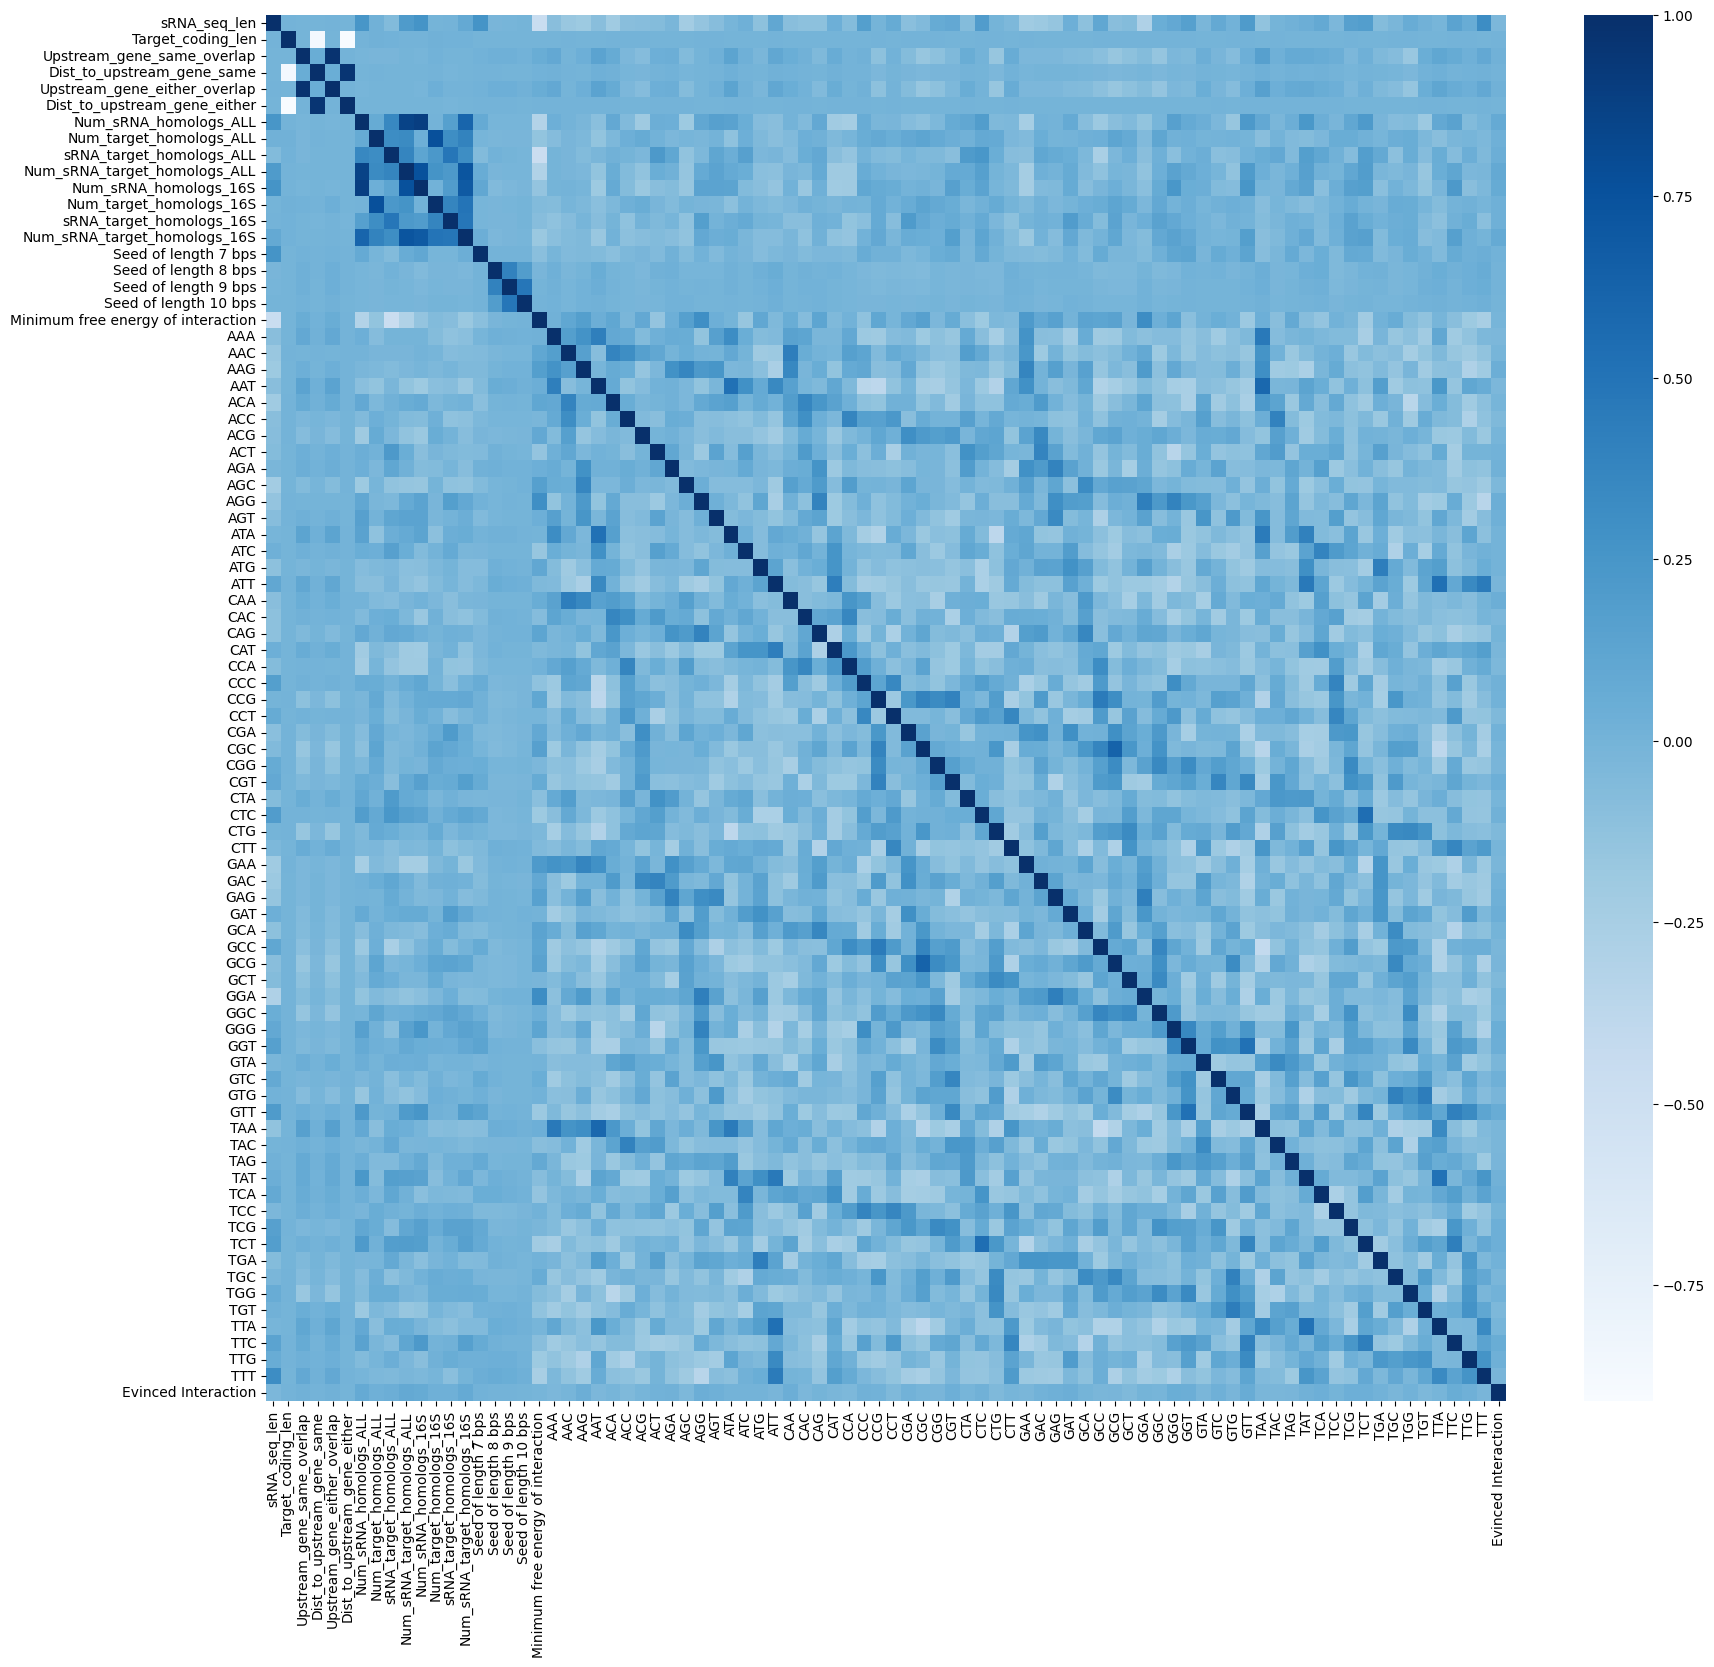

In [30]:
plt.figure(figsize = (20, 18))
sns.heatmap(df.corr(), cmap = 'Blues')
plt.show()

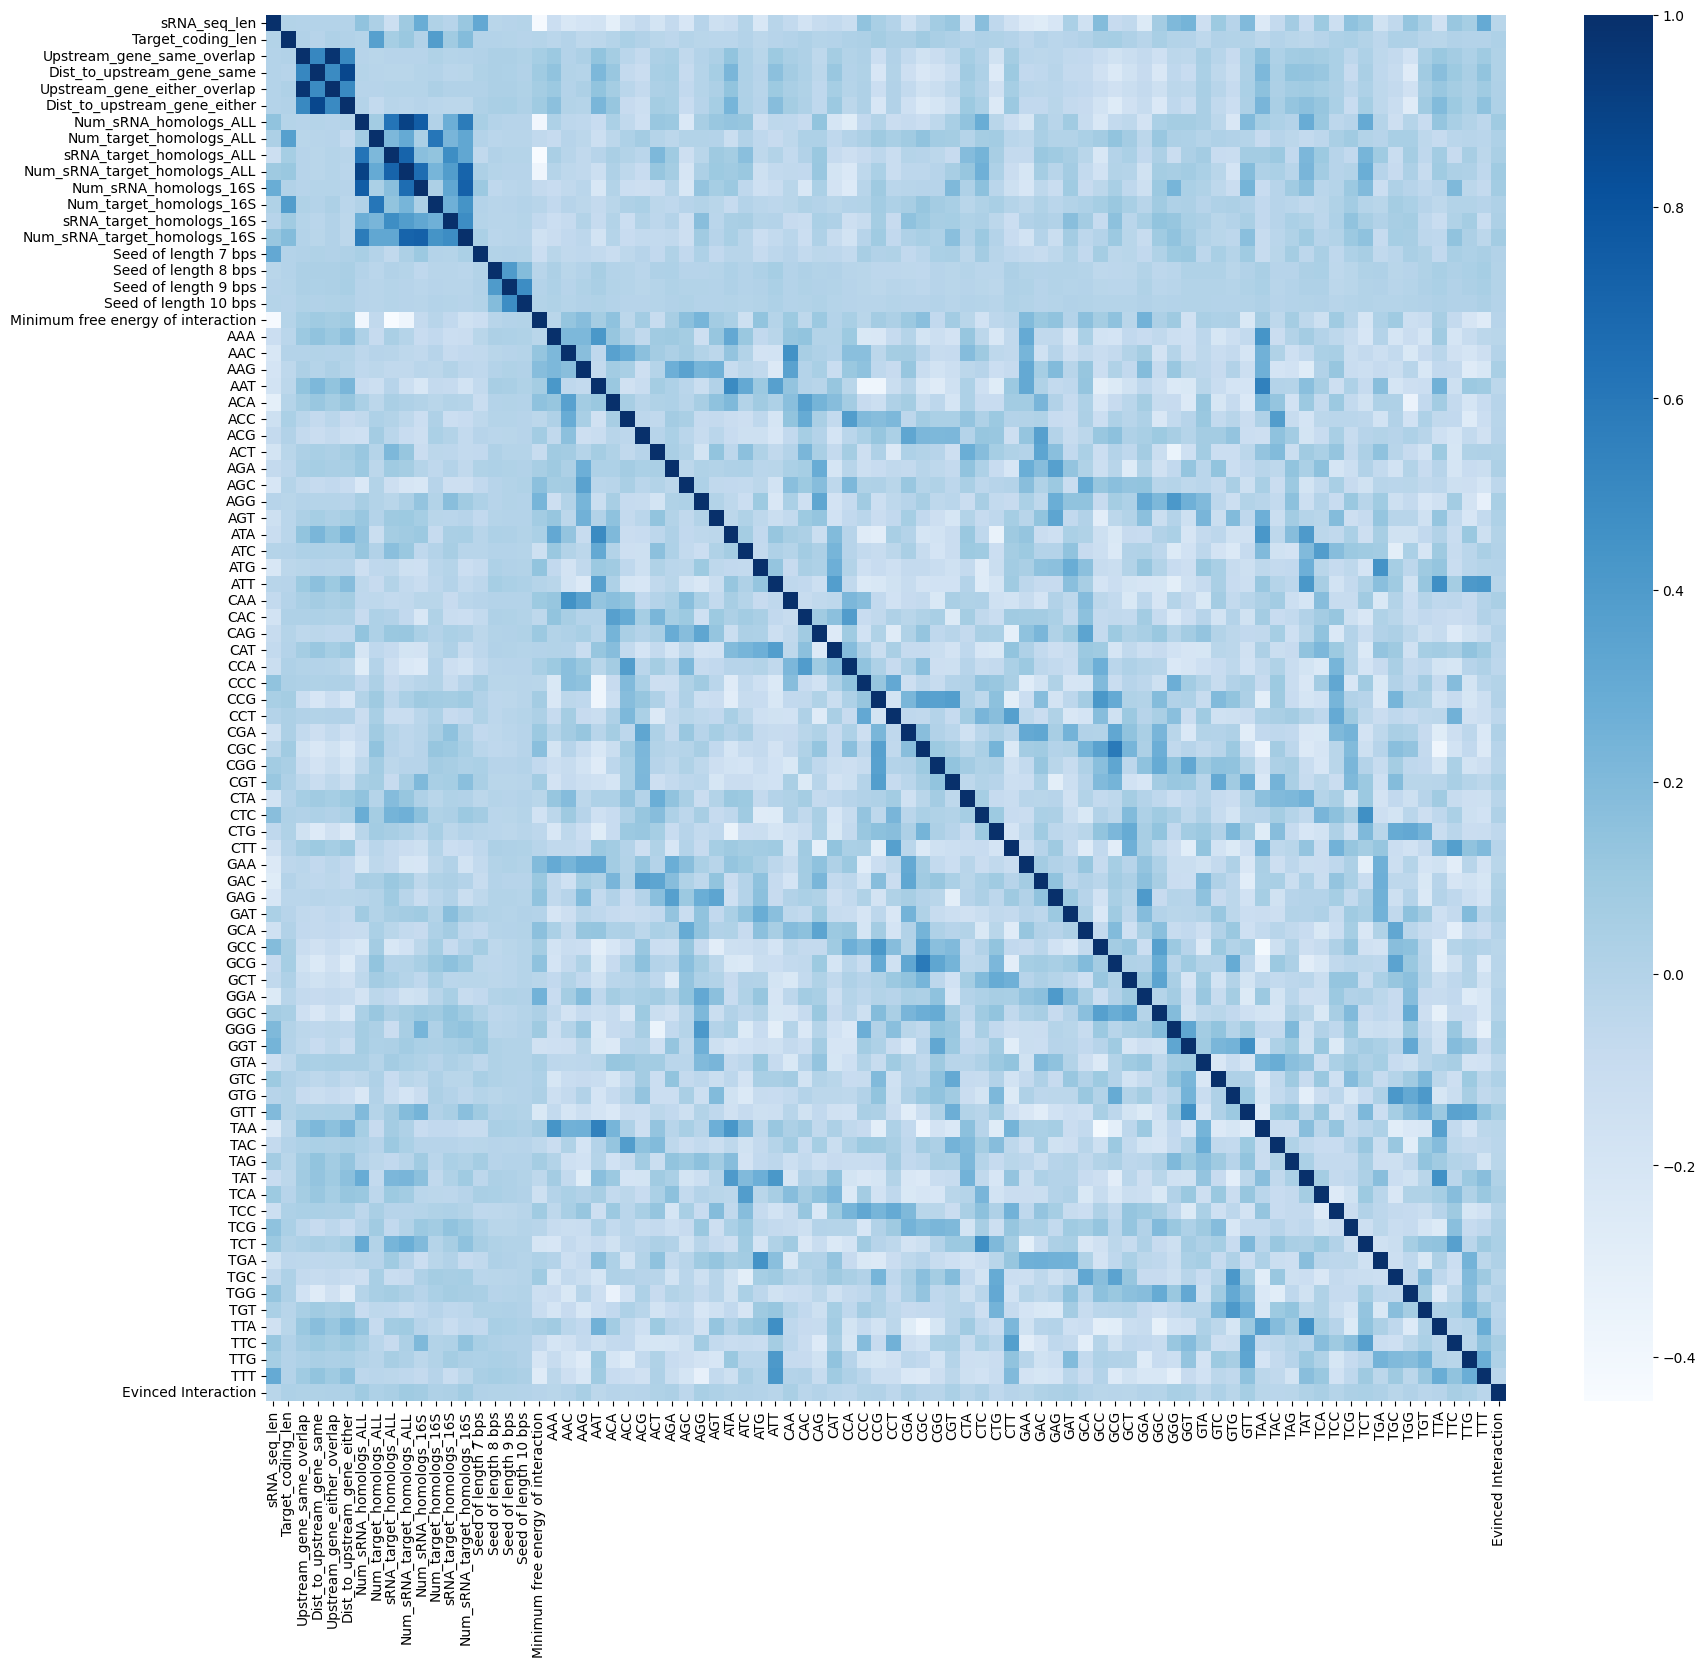

In [31]:
plt.figure(figsize = (20, 18))
sns.heatmap(df.corr(method = 'spearman'), cmap = 'Blues')
plt.show()

In [32]:
cor = df.corr()
cor_target = abs(cor["Evinced Interaction"])

relevant_features = cor_target
relevant_features = pd.DataFrame(relevant_features)
relevant_features.sort_values("Evinced Interaction" , ascending = False)

,Evinced Interaction
Evinced Interaction,1.000000
Num_sRNA_target_homologs_ALL,0.088816
Num_sRNA_target_homologs_16S,0.081021
Num_sRNA_homologs_ALL,0.079456
Num_sRNA_homologs_16S,0.070741
...,...
ATG,0.001237
Dist_to_upstream_gene_same,0.000738
GGA,0.000648
Seed of length 10 bps,0.000189


In [33]:
cor = df.corr(method = 'spearman')
cor_target = abs(cor["Evinced Interaction"])

relevant_features = cor_target
relevant_features = pd.DataFrame(relevant_features)
relevant_features.sort_values("Evinced Interaction" , ascending = False)

,Evinced Interaction
Evinced Interaction,1.000000
Num_sRNA_target_homologs_ALL,0.090787
Num_sRNA_homologs_ALL,0.085487
Num_sRNA_target_homologs_16S,0.078889
Num_sRNA_homologs_16S,0.077347
...,...
Seed of length 8 bps,0.001497
GGA,0.001398
GCA,0.001153
CAG,0.001042


In [37]:
num_rows = len(df)
random_variable_uniform = np.random.uniform(low = 0, high = 1, size = num_rows)
df['Random Variable (Uniform)'] = random_variable_uniform

cor = df.corr(method = 'spearman')
cor_target = abs(cor["Evinced Interaction"])

relevant_features = cor_target
relevant_features = pd.DataFrame(relevant_features)
relevant_features.sort_values("Evinced Interaction" , ascending = False)

,Evinced Interaction
Evinced Interaction,1.000000
Num_sRNA_target_homologs_ALL,0.090787
Num_sRNA_homologs_ALL,0.085487
Num_sRNA_target_homologs_16S,0.078889
Num_sRNA_homologs_16S,0.077347
...,...
GGA,0.001398
GCA,0.001153
CAG,0.001042
Random Variable (Uniform),0.000714


In [38]:
cor = df.corr()
cor_target = abs(cor["Evinced Interaction"])

relevant_features = cor_target
relevant_features = pd.DataFrame(relevant_features)
relevant_features.sort_values("Evinced Interaction" , ascending = False)

,Evinced Interaction
Evinced Interaction,1.000000
Num_sRNA_target_homologs_ALL,0.088816
Num_sRNA_target_homologs_16S,0.081021
Num_sRNA_homologs_ALL,0.079456
Num_sRNA_homologs_16S,0.070741
...,...
Dist_to_upstream_gene_same,0.000738
Random Variable (Uniform),0.000710
GGA,0.000648
Seed of length 10 bps,0.000189


In [39]:
df = df.drop(['Seed of length 10 bps', "Random Variable (Uniform)"], axis = 1)
df.head()

,sRNA_seq_len,Target_coding_len,Upstream_gene_same_overlap,Dist_to_upstream_gene_same,Upstream_gene_either_overlap,Dist_to_upstream_gene_either,Num_sRNA_homologs_ALL,Num_target_homologs_ALL,sRNA_target_homologs_ALL,Num_sRNA_target_homologs_ALL,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,Evinced Interaction
0,95,66,1,190,1,190,100,2,1,2,...,0.017422,0.013638,-0.021805,-0.003784,0.013937,0.013338,-0.000300,-0.018021,-0.057847,0
1,95,2463,1,81,1,81,100,100,1,75,...,0.006711,0.002670,-0.008768,-0.000686,0.006711,-0.008083,0.002670,-0.014794,-0.045067,0
2,95,933,1,1,1,1,100,96,1,76,...,0.016779,0.022804,0.008010,0.019449,0.013423,-0.004727,-0.000686,-0.001371,-0.065202,1
3,95,1287,1,0,1,0,100,99,1,71,...,0.013423,-0.000686,-0.018835,0.006026,0.016779,-0.021505,-0.000686,0.001985,-0.048423,0
4,95,297,1,213,1,213,100,62,1,58,...,0.020134,0.002670,-0.012124,0.002670,0.003356,0.001985,0.002670,-0.014794,-0.048423,0


In [7]:
forestmodel = RandomForestClassifier(n_estimators = 1024, max_depth = 9)
forestmodel.fit(df.drop(["Evinced Interaction"], axis = 1), df['Evinced Interaction'])

feature_importances = forestmodel.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': df.drop(["Evinced Interaction"], axis = 1).columns,
                                      'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by = 'Importance', ascending=False)

for index, row in feature_importance_df.iterrows():
    print(f"{row['Feature']} : {row['Importance']:.4f}")

ACC : 0.0681
GCT : 0.0421
CCT : 0.0412
Num_sRNA_target_homologs_ALL : 0.0332
Num_sRNA_homologs_ALL : 0.0276
Num_sRNA_homologs_16S : 0.0267
Minimum free energy of interaction : 0.0256
sRNA_seq_len : 0.0248
Target_coding_len : 0.0246
GTT : 0.0216
CCA : 0.0187
AAA : 0.0173
Num_sRNA_target_homologs_16S : 0.0169
TTT : 0.0164
TGT : 0.0153
GTA : 0.0151
Num_target_homologs_ALL : 0.0148
AAC : 0.0146
TAG : 0.0144
TTG : 0.0143
CAA : 0.0141
GTG : 0.0141
GGT : 0.0135
CTG : 0.0128
Dist_to_upstream_gene_either : 0.0124
GAG : 0.0121
TAA : 0.0119
GGG : 0.0114
ACA : 0.0113
AAG : 0.0107
GCG : 0.0104
Dist_to_upstream_gene_same : 0.0103
TGG : 0.0103
CAC : 0.0099
CTT : 0.0099
AGG : 0.0097
GCA : 0.0096
TAC : 0.0096
GCC : 0.0095
TTA : 0.0094
GAC : 0.0094
GAT : 0.0093
CCC : 0.0093
CGG : 0.0092
CGC : 0.0092
AGA : 0.0092
CGA : 0.0091
TCA : 0.0089
TTC : 0.0089
TGA : 0.0084
ATT : 0.0083
GGA : 0.0081
CAG : 0.0080
AGC : 0.0080
TCG : 0.0080
CTC : 0.0079
TCC : 0.0079
AAT : 0.0078
TGC : 0.0078
ATA : 0.0078
GAA : 0.0077

In [8]:
top_features = feature_importance_df.head(45)['Feature'].tolist()
df_selected_features = df[top_features + ["Evinced Interaction"]]

df_selected_features.head()

,ACC,GCT,CCT,Num_sRNA_target_homologs_ALL,Num_sRNA_homologs_ALL,Num_sRNA_homologs_16S,Minimum free energy of interaction,sRNA_seq_len,Target_coding_len,GTT,...,GCA,TAC,GCC,TTA,GAC,GAT,CCC,CGG,CGC,Evinced Interaction
0,0.013338,-0.032558,-0.014537,2,100,100,-45.0,95,66,0.003484,...,0.017122,0.013638,-0.014537,0.013338,-0.007568,-0.000300,-0.007268,-0.011052,0.003185,0
1,0.012052,-0.036299,-0.018150,75,100,100,-65.6,95,2463,0.013423,...,0.022804,0.009382,-0.011438,-0.008083,-0.008083,-0.004041,-0.007397,-0.004727,0.002670,0
2,-0.014794,-0.016165,-0.008083,76,100,100,-71.0,95,933,0.026846,...,-0.004041,0.002670,0.008696,-0.004727,-0.011438,0.012737,0.002670,0.008696,0.006026,1
3,-0.008083,-0.026232,-0.014794,71,100,100,-60.5,95,1287,0.023490,...,0.012737,0.002670,-0.001371,-0.021505,-0.011438,-0.004041,-0.000686,0.018763,0.019449,0
4,-0.011438,-0.029588,-0.014794,58,100,100,-59.0,95,297,0.013423,...,0.009382,-0.004041,-0.011438,0.001985,-0.014794,0.006026,0.006026,0.001985,-0.000686,0


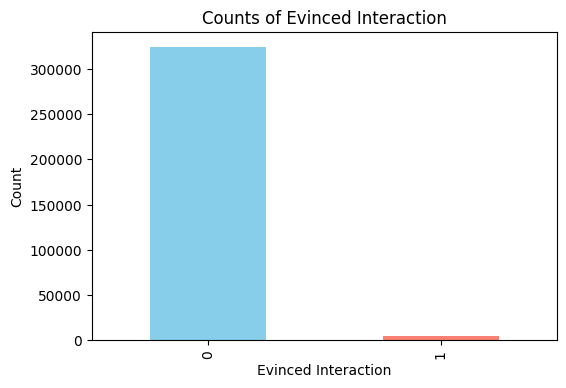

In [181]:
plt.figure(figsize = (6, 4))
df_selected_features['Evinced Interaction'].value_counts().plot(kind = 'bar', color = ['skyblue', 'salmon'])
plt.title('Counts of Evinced Interaction')
plt.xlabel('Evinced Interaction')
plt.ylabel('Count')
plt.show()

In [182]:
df_selected_features['Evinced Interaction'].value_counts()

Evinced Interaction
0    325162
1      4386
Name: count, dtype: int64

In [9]:
count_class_1 = len(df_selected_features[df_selected_features['Evinced Interaction'] == 1])
downsample_size_class_0 = 5 * count_class_1
downsampled_class_0 = df_selected_features[df_selected_features['Evinced Interaction'] == 0].sample(n = downsample_size_class_0, random_state = 8)
class_1 = df_selected_features[df_selected_features['Evinced Interaction'] == 1]
downsampled_df = pd.concat([downsampled_class_0, class_1])
downsampled_df = downsampled_df.sample(frac = 1, random_state = 8).reset_index(drop = True)
downsampled_df.head()

,ACC,GCT,CCT,Num_sRNA_target_homologs_ALL,Num_sRNA_homologs_ALL,Num_sRNA_homologs_16S,Minimum free energy of interaction,sRNA_seq_len,Target_coding_len,GTT,...,GCA,TAC,GCC,TTA,GAC,GAT,CCC,CGG,CGC,Evinced Interaction
0,0.006711,-0.009164,-0.006260,31,100,100,-44.4,106,456,0.013875,...,0.013875,0.016779,0.003807,0.007615,0.013423,0.004259,-0.035106,-0.002904,0.023490,1
1,0.016779,0.011333,-0.005445,5,5,7,-36.8,55,576,-0.020957,...,0.011333,0.010067,-0.002089,0.013423,0.013423,0.007978,0.003356,-0.024313,0.036913,0
2,0.006711,-0.005693,0.002187,1,2,4,-48.4,91,684,-0.009049,...,0.012254,0.006711,-0.020285,-0.057349,0.006711,-0.012405,0.010067,-0.019116,0.010067,0
3,0.006711,-0.013311,-0.001622,67,100,100,-67.7,122,852,0.025224,...,-0.003132,-0.014933,0.001734,0.010179,-0.006600,0.005201,0.000000,0.011801,-0.006600,0
4,-0.016745,0.008415,-0.006678,61,100,100,0.0,201,651,-0.021753,...,0.013440,-0.010033,0.000017,0.006745,-0.006695,0.006745,0.000017,-0.015059,0.021821,0


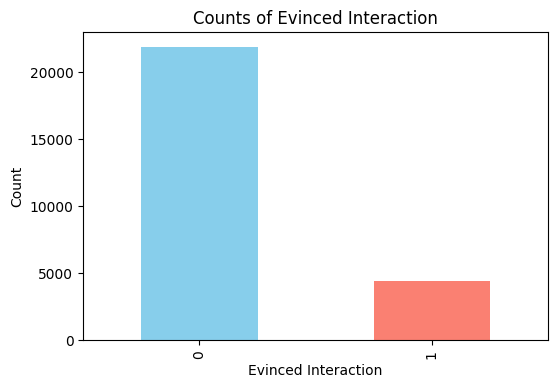

In [11]:
plt.figure(figsize = (6, 4))
downsampled_df['Evinced Interaction'].value_counts().plot(kind = 'bar', color = ['skyblue', 'salmon'])
plt.title('Counts of Evinced Interaction')
plt.xlabel('Evinced Interaction')
plt.ylabel('Count')
plt.show()

In [197]:
downsampled_df['Evinced Interaction'].value_counts()

Evinced Interaction
0    21930
1     4386
Name: count, dtype: int64

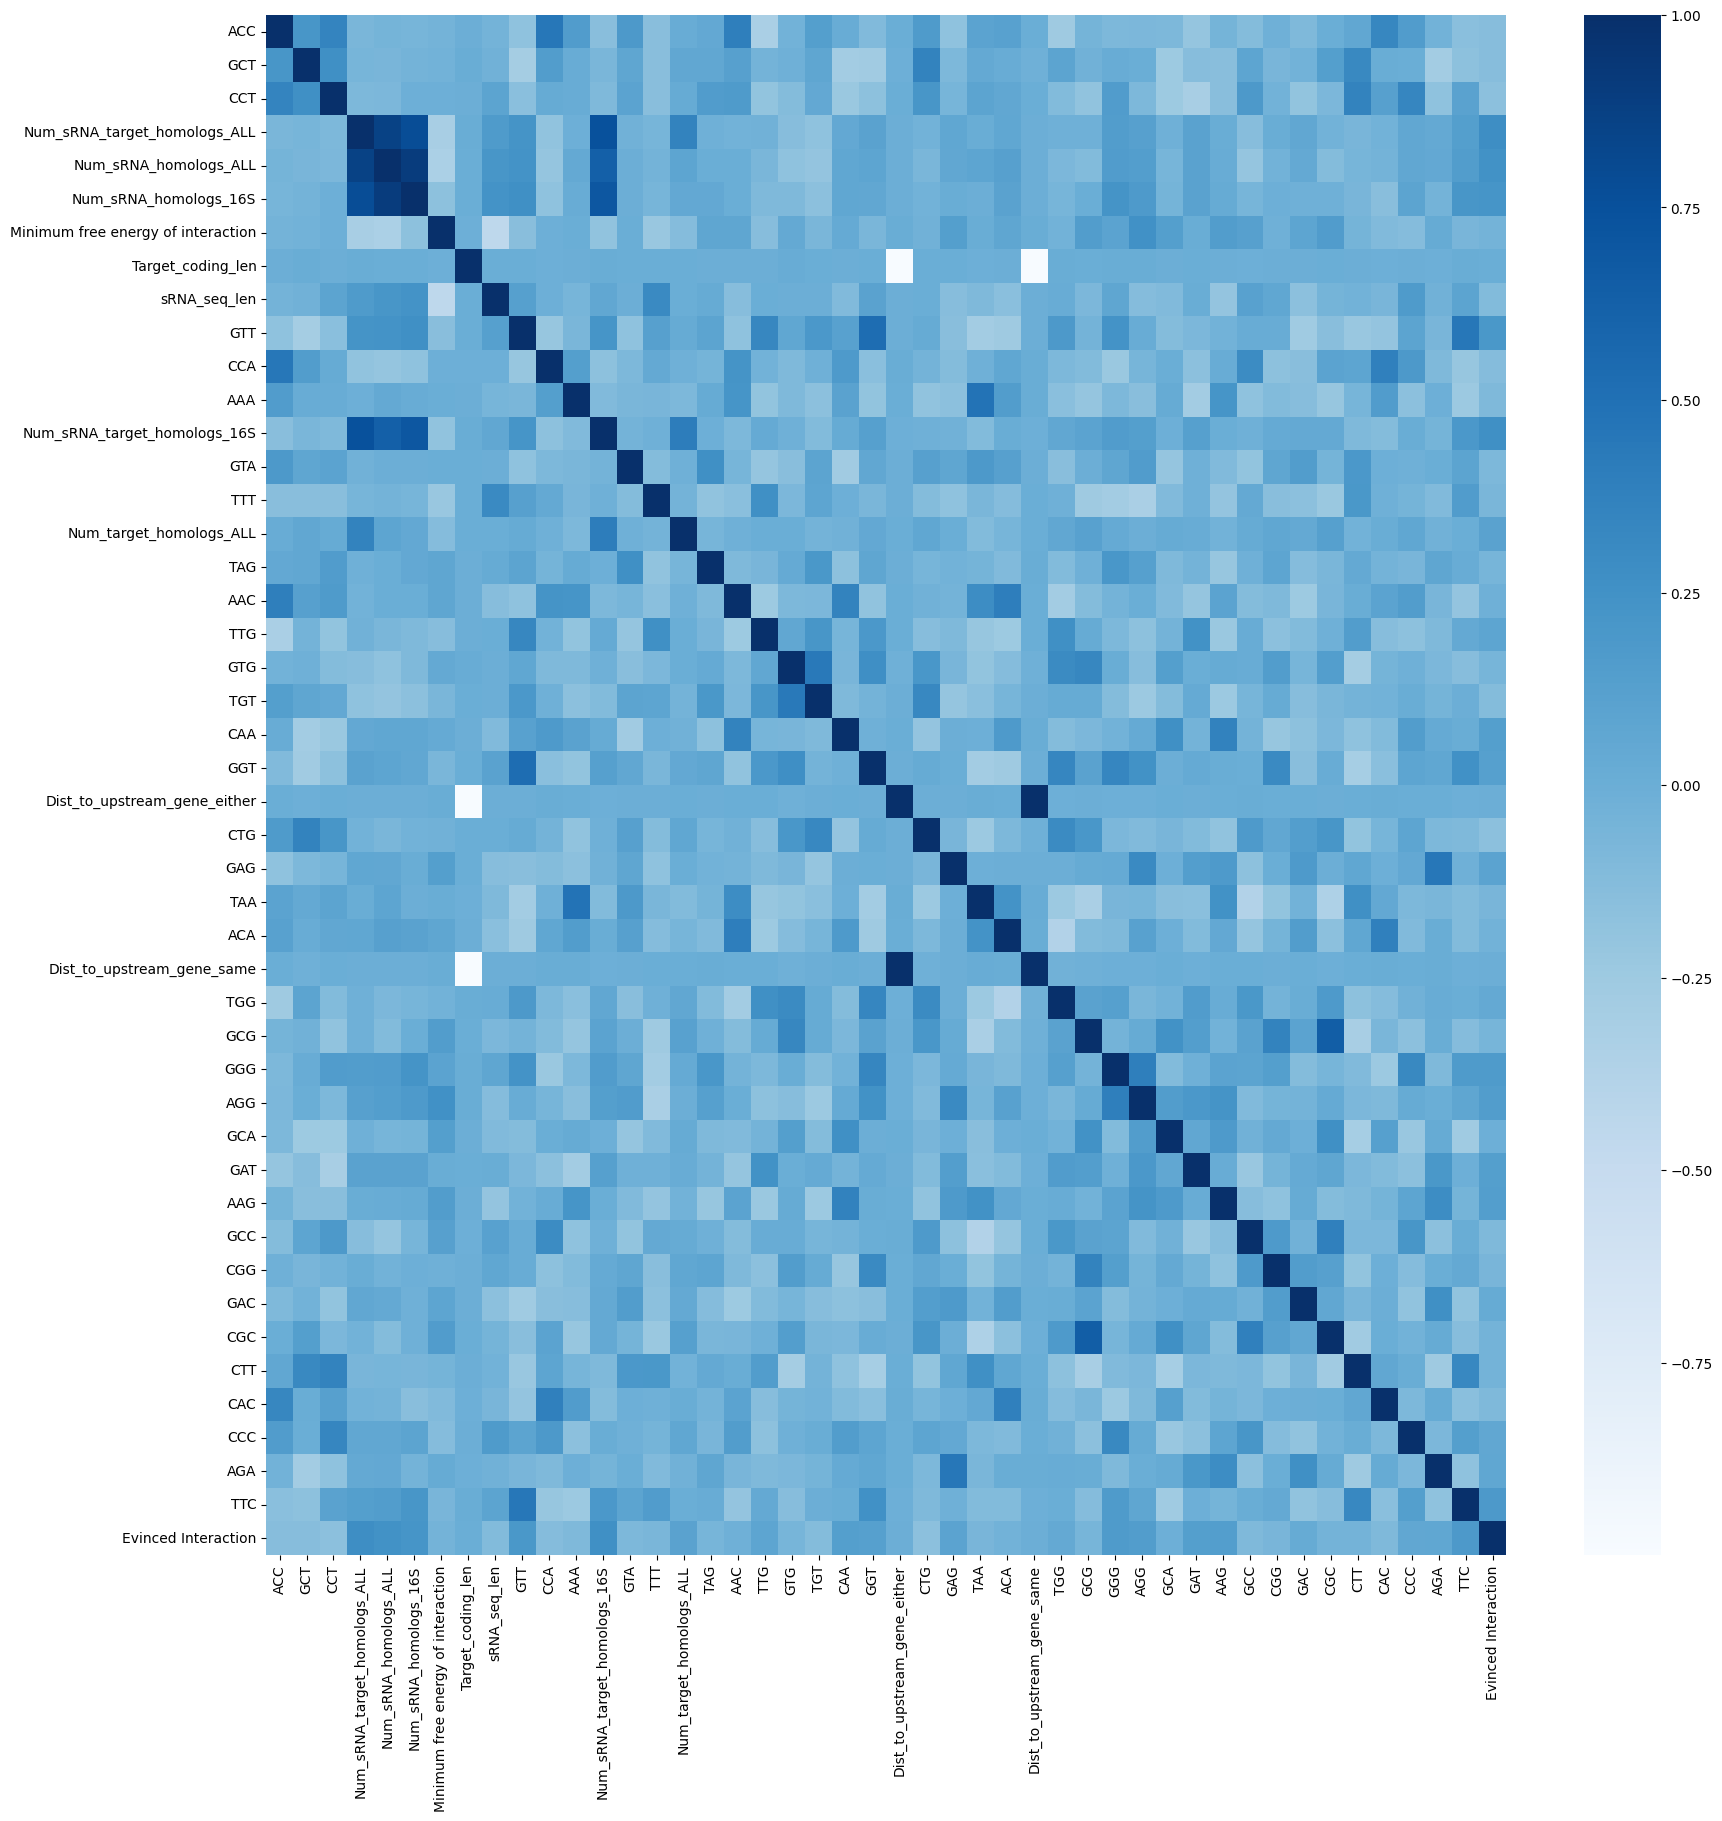

In [198]:
plt.figure(figsize = (20, 20))
sns.heatmap(downsampled_df.corr(), cmap = 'Blues')
plt.show()

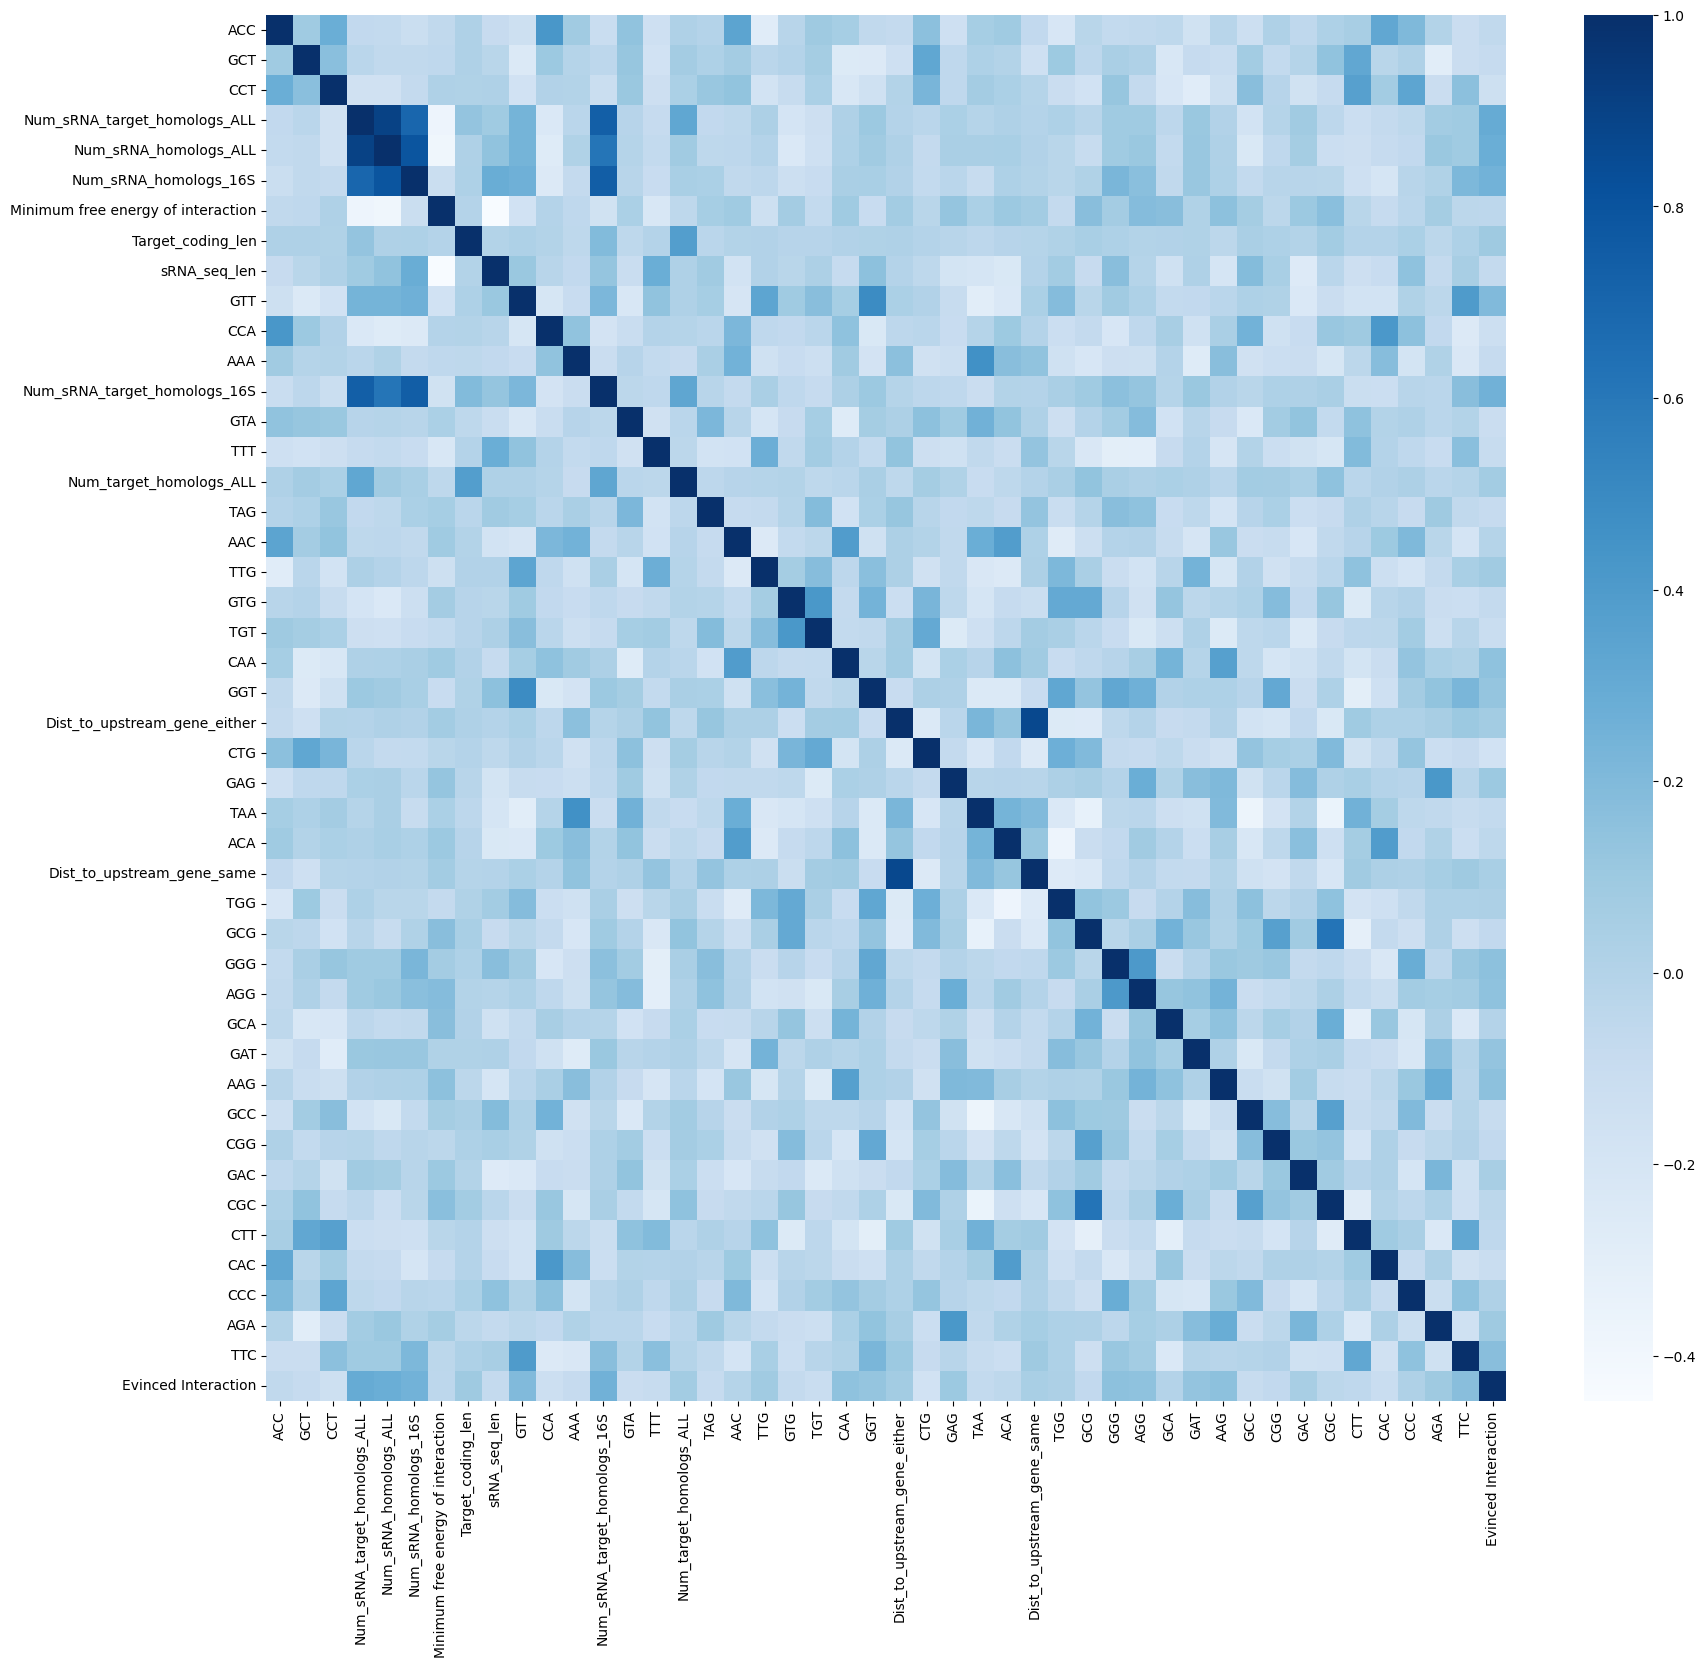

In [200]:
plt.figure(figsize = (20, 18))
sns.heatmap(downsampled_df.corr(method = 'spearman'), cmap = 'Blues')
plt.show()

In [201]:
cor = downsampled_df.corr()
cor_target = abs(cor["Evinced Interaction"])

relevant_features = cor_target
relevant_features = pd.DataFrame(relevant_features)
relevant_features.sort_values("Evinced Interaction" , ascending = False)

,Evinced Interaction
Evinced Interaction,1.000000
Num_sRNA_target_homologs_ALL,0.275361
Num_sRNA_target_homologs_16S,0.262569
Num_sRNA_homologs_ALL,0.250136
Num_sRNA_homologs_16S,0.225521
GTT,0.198759
TTC,0.180010
GGG,0.170873
CTG,0.162956
CCT,0.159265


In [12]:
cor = downsampled_df.corr(method = 'spearman')
cor_target = abs(cor["Evinced Interaction"])

relevant_features = cor_target
relevant_features = pd.DataFrame(relevant_features)
relevant_features.sort_values("Evinced Interaction" , ascending = False)

,Evinced Interaction
Evinced Interaction,1.000000
Num_sRNA_target_homologs_ALL,0.294995
Num_sRNA_homologs_ALL,0.277544
Num_sRNA_target_homologs_16S,0.257845
Num_sRNA_homologs_16S,0.250637
GTT,0.202750
CTG,0.166282
GGG,0.155090
AAG,0.152291
AGG,0.151192


In [13]:
for i in range(1, 1000):
    X_train, X_test, y_train, y_test = train_test_split(downsampled_df.drop('Evinced Interaction', axis = 1),
                                                        downsampled_df['Evinced Interaction'],
                                                        train_size = 0.8, random_state = i)
    num_features = 0
    for feature in X_train.columns:
        train = X_train[feature]
        test = X_test[feature]
        
        t_statistic, p_value = stats.ttest_ind(train, test)
        
        if p_value < 0.05:
            print(f"feature: {feature}, p-val: {p_value}")
            num_features += 1

    if num_features == 0:
        print(i)
        break

feature: Target_coding_len, p-val: 0.047057172518318265
feature: GTA, p-val: 0.013479927726164761
feature: GGT, p-val: 0.018979517590893277
feature: Dist_to_upstream_gene_either, p-val: 0.04639471165393249
feature: CGG, p-val: 0.013473133777506384
feature: GCT, p-val: 0.0015452623880237138
feature: CCT, p-val: 0.006126853986442116
feature: CAA, p-val: 0.029272316527560995
feature: GCG, p-val: 0.03505220068410247
feature: CAC, p-val: 0.008994617303052727
feature: CCC, p-val: 0.01463777742816775
feature: GTT, p-val: 0.013163564486036193
feature: GTG, p-val: 0.0006009483112427722
feature: CTG, p-val: 0.03867630744563421
feature: Num_sRNA_target_homologs_ALL, p-val: 0.0019408802401724432
feature: Num_sRNA_homologs_ALL, p-val: 0.04508317153869209
feature: Num_sRNA_homologs_16S, p-val: 0.014385443316249354
feature: Num_sRNA_target_homologs_16S, p-val: 0.0003479610130427546
feature: TGT, p-val: 0.04186524529074238
feature: TAA, p-val: 0.028121842079256335
feature: AAG, p-val: 0.01946465078233

In [218]:
X_train, X_test, y_train, y_test = train_test_split(downsampled_df.drop('Evinced Interaction', axis = 1),
                                                        to_categorical(downsampled_df['Evinced Interaction']),
                                                        train_size = 0.8, random_state = 11)
num_features = 0
for feature in X_train.columns:
    train = X_train[feature]
    test = X_test[feature]
    
    t_statistic, p_value = stats.ttest_ind(train, test)
    
    if p_value < 0.05:
        print(f"feature: {feature}, p-val: {p_value}")
        num_features += 1


In [17]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = True, restore_best_weights = False)
reduseLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, verbose = False)
tensorboard = TensorBoard(log_dir = './TensorboardRuns/Model1/')

In [220]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components = X_train.shape[1] // 4)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [221]:
inp = Input(shape = (X_train.shape[1], ))
body = Dense(256, activation = 'elu')(inp)
body = Dense(128, activation = 'elu')(body)
body = Dense(64, activation = 'elu')(body)
body = Dense(2, activation = 'softmax')(body)

model = Model(inputs = inp, outputs = body)
model.compile(optimizer = Adam(learning_rate = 0.01), loss ='binary_crossentropy', metrics = ['accuracy'])

hist = model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = [X_test, y_test],
                 callbacks = [early_stopping, reduseLR, tensorboard])

Epoch 1/100
658/658 [==============================] - 8s 9ms/step - loss: 0.3587 - accuracy: 0.8521 - val_loss: 0.3400 - val_accuracy: 0.8558 - lr: 0.0100
Epoch 2/100
658/658 [==============================] - 5s 8ms/step - loss: 0.3455 - accuracy: 0.8586 - val_loss: 0.3270 - val_accuracy: 0.8634 - lr: 0.0100
Epoch 3/100
658/658 [==============================] - 6s 9ms/step - loss: 0.3353 - accuracy: 0.8591 - val_loss: 0.3350 - val_accuracy: 0.8617 - lr: 0.0100
Epoch 4/100
658/658 [==============================] - 5s 8ms/step - loss: 0.3248 - accuracy: 0.8637 - val_loss: 0.3227 - val_accuracy: 0.8642 - lr: 0.0100
Epoch 5/100
658/658 [==============================] - 5s 8ms/step - loss: 0.3212 - accuracy: 0.8650 - val_loss: 0.3108 - val_accuracy: 0.8655 - lr: 0.0100
Epoch 6/100
658/658 [==============================] - 6s 8ms/step - loss: 0.3211 - accuracy: 0.8622 - val_loss: 0.3074 - val_accuracy: 0.8661 - lr: 0.0100
Epoch 7/100
658/658 [==============================] - 5s 8ms/st

165/165 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      4380
           1       0.70      0.37      0.48       884

    accuracy                           0.87      5264
   macro avg       0.79      0.67      0.70      5264
weighted avg       0.85      0.87      0.85      5264

Confusion Matrix:


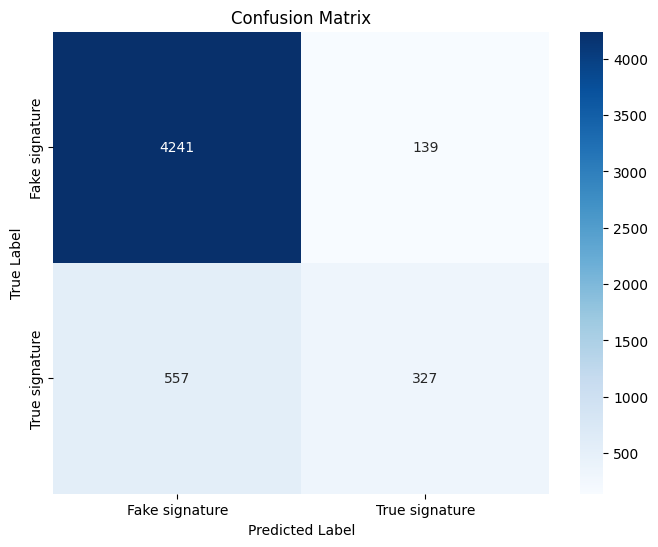

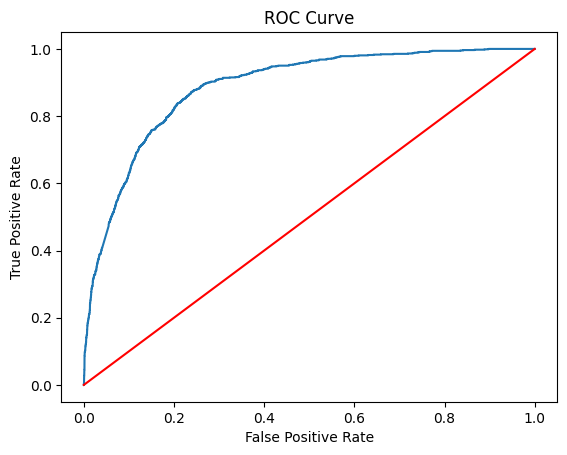

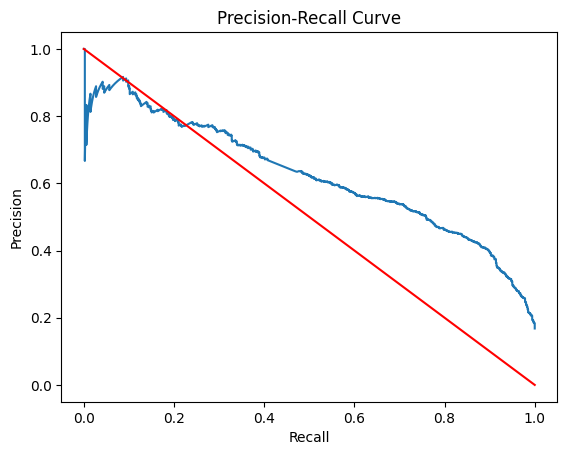

ROC-AUC Score: 0.8859781452096117
Kappa: 0.4168345400693225
MCC: 0.44502126288679067


In [224]:
evaluate_model(model, X_test, y_test)

Epoch 1/100
658/658 [==============================] - 23s 16ms/step - loss: 0.3822 - accuracy: 0.8403 - val_loss: 0.3332 - val_accuracy: 0.8642 - lr: 0.0100
Epoch 2/100
658/658 [==============================] - 12s 18ms/step - loss: 0.3473 - accuracy: 0.8531 - val_loss: 0.3193 - val_accuracy: 0.8691 - lr: 0.0100
Epoch 3/100
658/658 [==============================] - 10s 16ms/step - loss: 0.3435 - accuracy: 0.8522 - val_loss: 0.3108 - val_accuracy: 0.8678 - lr: 0.0100
Epoch 4/100
658/658 [==============================] - 10s 15ms/step - loss: 0.3349 - accuracy: 0.8594 - val_loss: 0.3112 - val_accuracy: 0.8672 - lr: 0.0100
Epoch 5/100
658/658 [==============================] - 11s 17ms/step - loss: 0.3371 - accuracy: 0.8550 - val_loss: 0.3174 - val_accuracy: 0.8663 - lr: 0.0100
Epoch 6/100
658/658 [==============================] - 12s 18ms/step - loss: 0.3352 - accuracy: 0.8568 - val_loss: 0.3096 - val_accuracy: 0.8642 - lr: 0.0100
Epoch 7/100
658/658 [==============================]

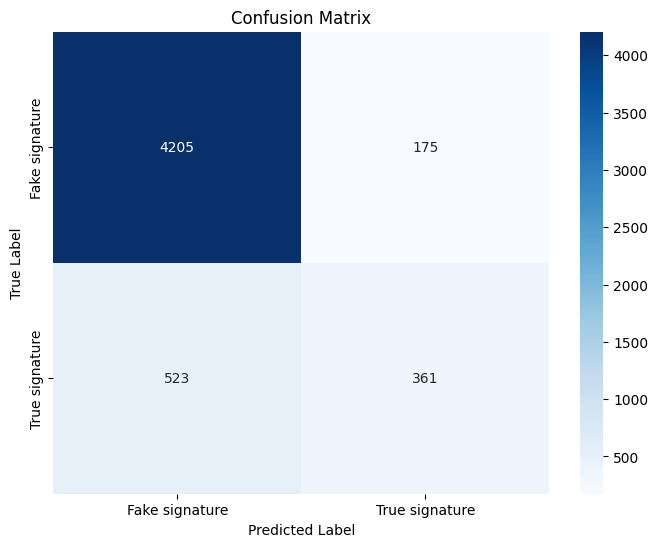

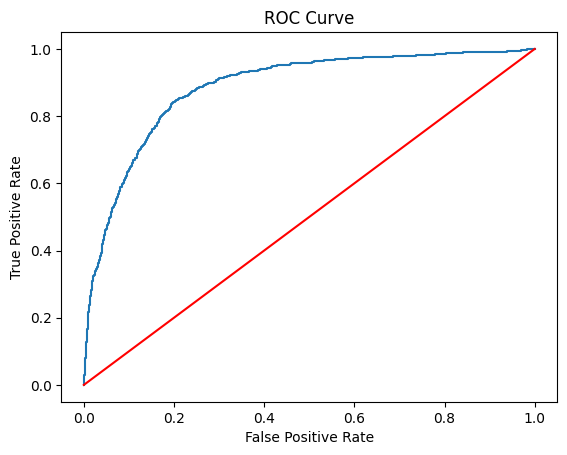

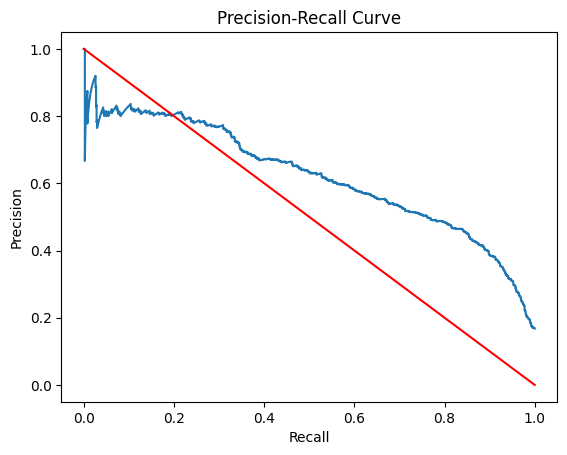

ROC-AUC Score: 0.8847184342651708
Kappa: 0.4370857355767346
MCC: 0.4553877779010891


In [225]:
inp = Input(shape = (X_train.shape[1], ))
body = BatchNormalization()(inp)
body = Dense(256, activation = 'elu')(body)
body = BatchNormalization()(body)
body = Dropout(0.5)(body)
body = Dense(128, activation = 'elu')(body)
body = BatchNormalization()(body)
body = Dropout(0.5)(body)
body = Dense(64, activation = 'elu')(body)
body = BatchNormalization()(body)
body = Dropout(0.5)(body)
body = Dense(2, activation = 'softmax')(body)

tensorboard = TensorBoard(log_dir = './TensorboardRuns/Model2/')

model = Model(inputs = inp, outputs = body)
model.compile(optimizer = Adam(learning_rate = 0.01), loss ='binary_crossentropy', metrics = ['accuracy'])

hist = model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = [X_test, y_test],
                 callbacks = [early_stopping, reduseLR, tensorboard])

evaluate_model(model, X_test, y_test)

Epoch 1/100
658/658 [==============================] - 9s 12ms/step - loss: 0.3829 - accuracy: 0.8450 - val_loss: 0.6651 - val_accuracy: 0.8573 - lr: 0.0100
Epoch 2/100
658/658 [==============================] - 6s 9ms/step - loss: 0.3784 - accuracy: 0.8495 - val_loss: 0.3561 - val_accuracy: 0.8575 - lr: 0.0100
Epoch 3/100
658/658 [==============================] - 7s 11ms/step - loss: 0.3707 - accuracy: 0.8517 - val_loss: 0.3483 - val_accuracy: 0.8541 - lr: 0.0100
Epoch 4/100
658/658 [==============================] - 7s 10ms/step - loss: 0.3669 - accuracy: 0.8495 - val_loss: 0.3265 - val_accuracy: 0.8651 - lr: 0.0100
Epoch 5/100
658/658 [==============================] - 8s 12ms/step - loss: 0.3721 - accuracy: 0.8528 - val_loss: 0.3790 - val_accuracy: 0.8321 - lr: 0.0100
Epoch 6/100
658/658 [==============================] - 5s 8ms/step - loss: 0.3813 - accuracy: 0.8455 - val_loss: 0.3538 - val_accuracy: 0.8302 - lr: 0.0100
Epoch 7/100
653/658 [============================>.] - ETA: 

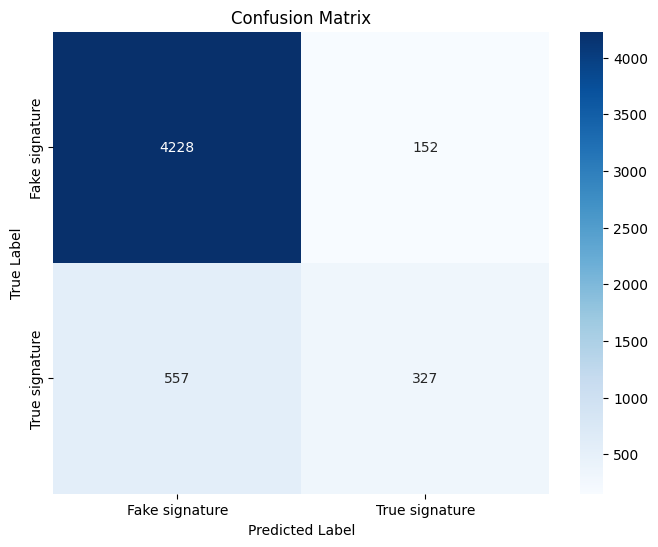

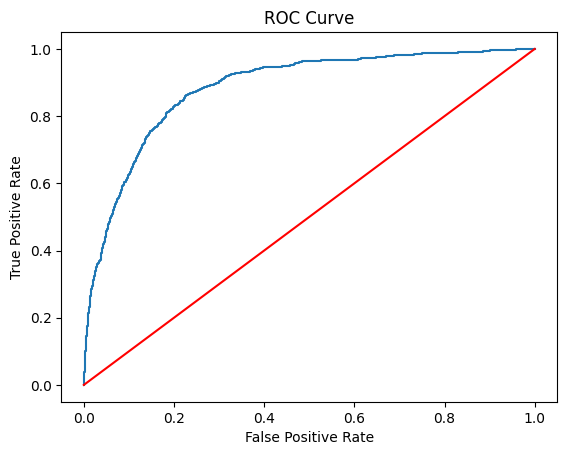

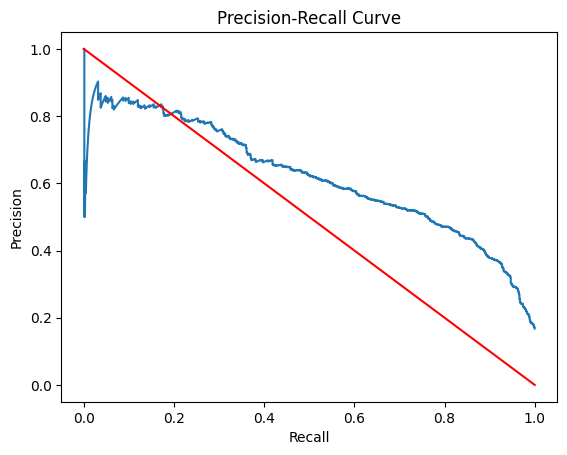

ROC-AUC Score: 0.8835753321349615
Kappa: 0.41020866124311783
MCC: 0.4356790128623922


In [226]:
inp = Input(shape = (X_train.shape[1], ))
body = BatchNormalization()(inp)
body = Dense(256, activation = 'elu')(body)
body = Dropout(0.25)(body)
body = Dense(128, activation = 'elu')(body)
body = Dropout(0.25)(body)
body = Dense(64, activation = 'elu')(body)
body = Dropout(0.25)(body)
body = Dense(2, activation = 'softmax')(body)

tensorboard = TensorBoard(log_dir = './TensorboardRuns/Model3/')

model = Model(inputs = inp, outputs = body)
model.compile(optimizer = Adam(learning_rate = 0.01), loss ='binary_crossentropy', metrics = ['accuracy'])

hist = model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = [X_test, y_test],
                 callbacks = [early_stopping, reduseLR, tensorboard])

evaluate_model(model, X_test, y_test)

In [242]:
X_train, X_test, y_train, y_test = train_test_split(downsampled_df.drop('Evinced Interaction', axis = 1),
                                                        to_categorical(downsampled_df['Evinced Interaction']),
                                                        train_size = 0.8, random_state = 11)
num_features = 0
for feature in X_train.columns:
    train = X_train[feature]
    test = X_test[feature]
    
    t_statistic, p_value = stats.ttest_ind(train, test)
    
    if p_value < 0.05:
        print(f"feature: {feature}, p-val: {p_value}")
        num_features += 1

In [243]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

umap_ = umap.UMAP(n_components = X_train.shape[1] // 4)
X_train = umap_.fit_transform(X_train)
X_test = umap_.transform(X_test)

Epoch 1/100
658/658 [==============================] - 15s 18ms/step - loss: 0.3856 - accuracy: 0.8418 - val_loss: 0.3217 - val_accuracy: 0.8596 - lr: 0.0100
Epoch 2/100
658/658 [==============================] - 12s 19ms/step - loss: 0.3397 - accuracy: 0.8563 - val_loss: 0.3228 - val_accuracy: 0.8611 - lr: 0.0100
Epoch 3/100
658/658 [==============================] - 12s 19ms/step - loss: 0.3346 - accuracy: 0.8561 - val_loss: 0.3174 - val_accuracy: 0.8613 - lr: 0.0100
Epoch 4/100
658/658 [==============================] - 13s 20ms/step - loss: 0.3277 - accuracy: 0.8585 - val_loss: 0.3108 - val_accuracy: 0.8611 - lr: 0.0100
Epoch 5/100
658/658 [==============================] - 12s 19ms/step - loss: 0.3288 - accuracy: 0.8572 - val_loss: 0.3141 - val_accuracy: 0.8611 - lr: 0.0100
Epoch 6/100
658/658 [==============================] - 10s 16ms/step - loss: 0.3263 - accuracy: 0.8586 - val_loss: 0.3145 - val_accuracy: 0.8611 - lr: 0.0100
Epoch 7/100
658/658 [==============================]

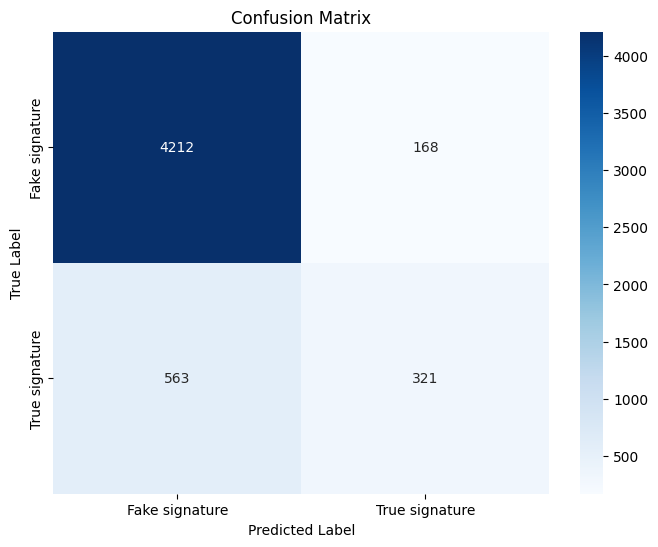

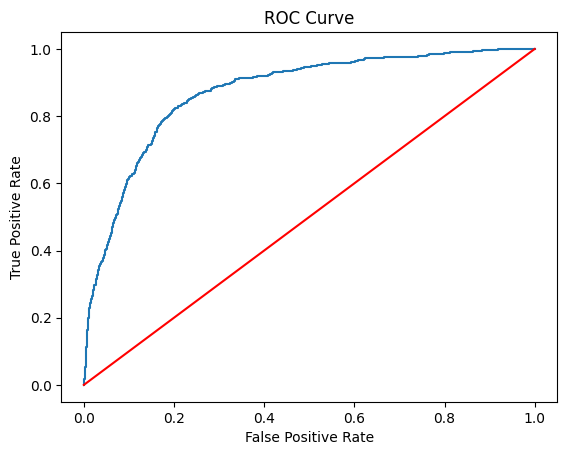

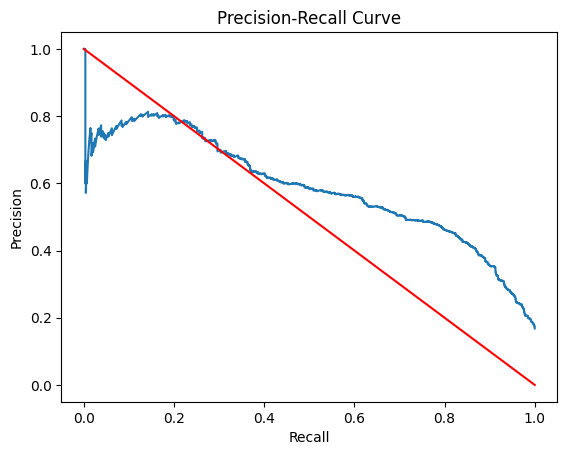

ROC-AUC Score: 0.8717398603276927
Kappa: 0.3952487222847372
MCC: 0.41820828926818854


In [244]:
inp = Input(shape = (X_train.shape[1], ))
body = BatchNormalization()(inp)
body = Dense(256, activation = 'elu')(body)
body = BatchNormalization()(body)
body = Dropout(0.5)(body)
body = Dense(128, activation = 'elu')(body)
body = BatchNormalization()(body)
body = Dropout(0.5)(body)
body = Dense(64, activation = 'elu')(body)
body = BatchNormalization()(body)
body = Dropout(0.5)(body)
body = Dense(2, activation = 'softmax')(body)

tensorboard = TensorBoard(log_dir = './TensorboardRuns/Model4/')

model = Model(inputs = inp, outputs = body)
model.compile(optimizer = Adam(learning_rate = 0.01), loss ='binary_crossentropy', metrics = ['accuracy'])

hist = model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = [X_test, y_test],
                 callbacks = [early_stopping, reduseLR, tensorboard])

evaluate_model(model, X_test, y_test)

In [246]:
X_train, X_test, y_train, y_test = train_test_split(downsampled_df.drop('Evinced Interaction', axis = 1),
                                                        to_categorical(downsampled_df['Evinced Interaction']),
                                                        train_size = 0.8, random_state = 11)
num_features = 0
for feature in X_train.columns:
    train = X_train[feature]
    test = X_test[feature]
    
    t_statistic, p_value = stats.ttest_ind(train, test)
    
    if p_value < 0.05:
        print(f"feature: {feature}, p-val: {p_value}")
        num_features += 1


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components = X_train.shape[1] // 4)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Epoch 1/100
658/658 [==============================] - 26s 33ms/step - loss: 0.3848 - accuracy: 0.8401 - val_loss: 0.3235 - val_accuracy: 0.8604 - lr: 0.0100
Epoch 2/100
658/658 [==============================] - 23s 35ms/step - loss: 0.3484 - accuracy: 0.8517 - val_loss: 0.3242 - val_accuracy: 0.8684 - lr: 0.0100
Epoch 3/100
658/658 [==============================] - 21s 31ms/step - loss: 0.3401 - accuracy: 0.8556 - val_loss: 0.3164 - val_accuracy: 0.8676 - lr: 0.0100
Epoch 4/100
658/658 [==============================] - 24s 36ms/step - loss: 0.3372 - accuracy: 0.8557 - val_loss: 0.3123 - val_accuracy: 0.8678 - lr: 0.0100
Epoch 5/100
658/658 [==============================] - 22s 33ms/step - loss: 0.3376 - accuracy: 0.8549 - val_loss: 0.3076 - val_accuracy: 0.8661 - lr: 0.0100
Epoch 6/100
658/658 [==============================] - 24s 36ms/step - loss: 0.3355 - accuracy: 0.8585 - val_loss: 0.3086 - val_accuracy: 0.8661 - lr: 0.0100
Epoch 7/100
658/658 [==============================]

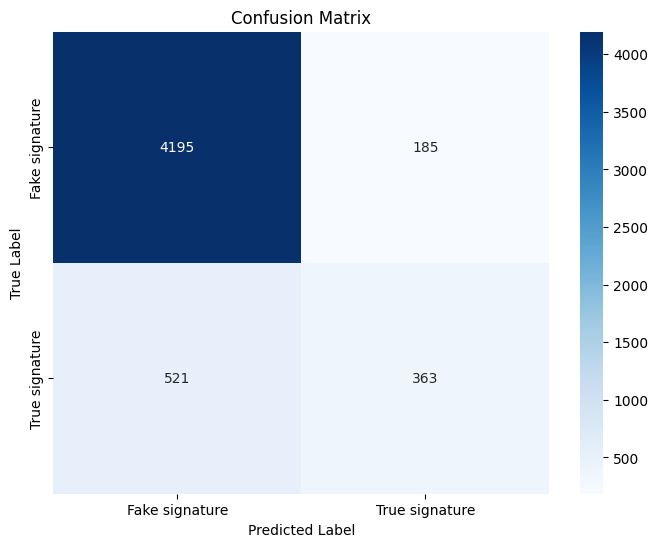

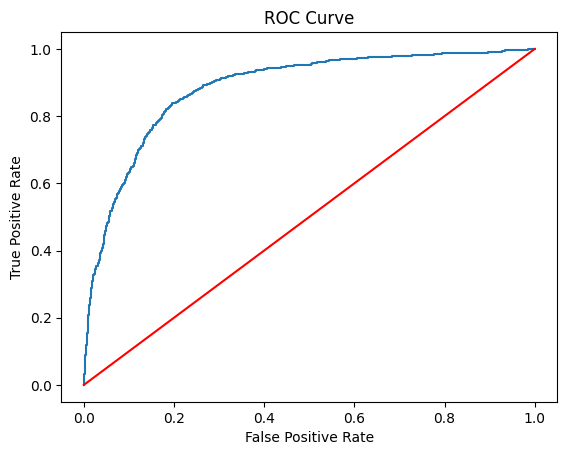

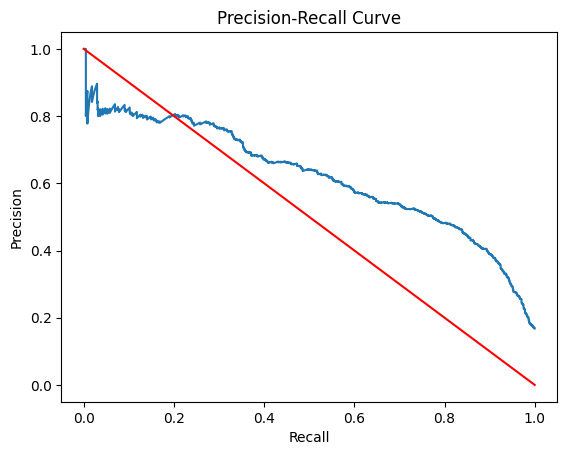

ROC-AUC Score: 0.88374501539288
Kappa: 0.43427007068153367
MCC: 0.4509215227730146


In [247]:
inp = Input(shape = (X_train.shape[1], ))
body = BatchNormalization()(inp)
body = Dense(256, activation = 'elu')(body)
body = BatchNormalization()(body)
body = Dropout(0.5)(body)
body = Dense(128, activation = 'elu')(body)
body = BatchNormalization()(body)
body = Dropout(0.5)(body)
body = Dense(64, activation = 'elu')(body)
body = BatchNormalization()(body)
body = Dropout(0.5)(body)
body = Dense(2, activation = 'softmax')(body)

tensorboard = TensorBoard(log_dir = './TensorboardRuns/Model5/')

model = Model(inputs = inp, outputs = body)
model.compile(optimizer = Nadam(learning_rate = 0.01), loss ='binary_crossentropy', metrics = ['accuracy'])

hist = model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = [X_test, y_test],
                 callbacks = [early_stopping, reduseLR, tensorboard])

evaluate_model(model, X_test, y_test)

Epoch 1/100
658/658 [==============================] - 21s 27ms/step - loss: 0.3748 - accuracy: 0.8472 - val_loss: 0.3613 - val_accuracy: 0.8638 - lr: 0.0100
Epoch 2/100
658/658 [==============================] - 17s 26ms/step - loss: 0.3499 - accuracy: 0.8556 - val_loss: 0.3279 - val_accuracy: 0.8623 - lr: 0.0100
Epoch 3/100
658/658 [==============================] - 17s 26ms/step - loss: 0.3414 - accuracy: 0.8574 - val_loss: 0.3166 - val_accuracy: 0.8649 - lr: 0.0100
Epoch 4/100
658/658 [==============================] - 17s 26ms/step - loss: 0.3416 - accuracy: 0.8591 - val_loss: 0.3095 - val_accuracy: 0.8659 - lr: 0.0100
Epoch 5/100
658/658 [==============================] - 18s 27ms/step - loss: 0.3382 - accuracy: 0.8589 - val_loss: 0.3177 - val_accuracy: 0.8670 - lr: 0.0100
Epoch 6/100
658/658 [==============================] - 18s 27ms/step - loss: 0.3356 - accuracy: 0.8609 - val_loss: 0.3150 - val_accuracy: 0.8668 - lr: 0.0100
Epoch 7/100
657/658 [============================>.]

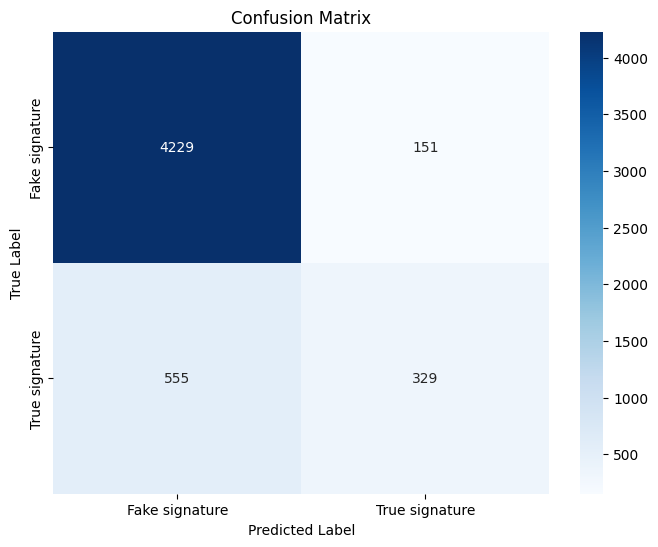

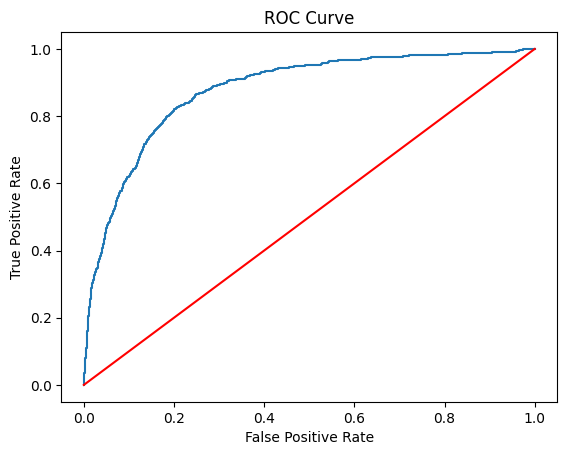

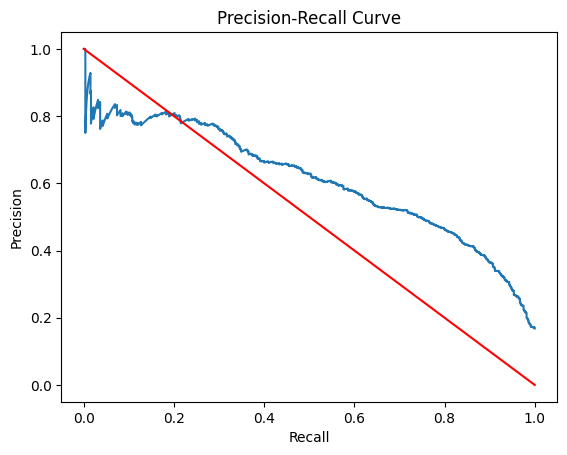

ROC-AUC Score: 0.8768406888572078
Kappa: 0.41302853561645214
MCC: 0.4385047105688453


In [249]:
inp = Input(shape = (X_train.shape[1], ))
body = BatchNormalization()(inp)
body = Dense(256, activation = 'elu')(body)
body = BatchNormalization()(body)
body = Dropout(0.5)(body)
body = Dense(128, activation = 'elu')(body)
body = BatchNormalization()(body)
body = Dropout(0.5)(body)
body = Dense(64, activation = 'elu')(body)
body = BatchNormalization()(body)
body = Dropout(0.5)(body)
body = Dense(2, activation = 'softmax')(body)

tensorboard = TensorBoard(log_dir = './TensorboardRuns/Model6/')

model = Model(inputs = inp, outputs = body)
model.compile(optimizer = RMSprop(learning_rate = 0.01), loss ='binary_crossentropy', metrics = ['accuracy'])

hist = model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = [X_test, y_test],
                 callbacks = [early_stopping, reduseLR, tensorboard])

evaluate_model(model, X_test, y_test)

In [45]:
class sRNAHunter():
    def __init__(self, n_layers = 2, n_neurons = 16, n_components = 40):
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.n_components = n_components
    
    def get_params(self, deep = True):
        return {
            'n_layers': self.n_layers,
            'n_neurons': self.n_neurons,
            'n_components' : self.n_components
        }
    
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

    
    def create_model(self): 
        print(self.get_params())
        inp = Input(shape = (self.X_test.shape[1], ))
        self.model = Dense(units = self.n_neurons, activation = 'elu')(inp)
        self.model = BatchNormalization()(self.model)
        self.model = Dropout(0.5)(self.model)
        for i in range(self.n_layers - 2):
            self.model = Dense(units = max(self.n_neurons // (i + 2), 4), activation = 'elu')(self.model)
            self.model = BatchNormalization()(self.model)
            self.model = Dropout(0.5)(self.model)

        self.model = Dense(units = 2, activation = 'softmax')(self.model)

        self.model = Model(inputs = inp, outputs = self.model)
        self.model.compile(optimizer = Nadam(learning_rate = 0.01), loss ='binary_crossentropy', metrics = ['accuracy'])

    
    def fit(self, X, y):
        X_train, X_test, y_train, self.y_test = train_test_split(downsampled_df.drop('Evinced Interaction', axis = 1),
                                                        to_categorical(downsampled_df['Evinced Interaction']),
                                                        train_size = 0.8, random_state = 11)

        self.scaler = StandardScaler()
        X_train = self.scaler.fit_transform(X_train)
        self.X_test = self.scaler.transform(X_test)

        self.pca = PCA(n_components = self.n_components)
        X_train = self.pca.fit_transform(X_train)
        self.X_test = self.pca.transform(self.X_test)

        self.create_model()
        tensorboard = TensorBoard(log_dir = './TensorboardRuns/Model7/')
        hist = self.model.fit(X_train, y_train, batch_size = 256, epochs = 100, validation_data = [self.X_test, self.y_test],
                 callbacks = [early_stopping, reduseLR, tensorboard], verbose = False)

        predicted_values = self.model.predict(X_train)
        # print(f1_score(np.argmax(y_train, axis = 1), np.argmax(predicted_values, axis = 1)))
        return f1_score(np.argmax(y_train, axis = 1), np.argmax(predicted_values, axis = 1))


    def score(self, X, y):
        predicted_values = self.model.predict(self.X_test)
        print(f1_score(np.argmax(self.y_test, axis = 1), np.argmax(predicted_values, axis = 1)))
        print("\n")
        return f1_score(np.argmax(self.y_test, axis = 1), np.argmax(predicted_values, axis = 1))


In [46]:
param_dist = {
    'n_layers': np.arange(2, 10, 1),
    'n_neurons' : np.arange(8, 354, 4),
    'n_components' : np.arange(5, 40, 1)
}

random_search = RandomizedSearchCV(sRNAHunter(), param_distributions = param_dist, n_iter = 35, cv = 2)

random_search.fit(np.zeros((10, 10)), np.zeros(10))

best_params = random_search.best_params_
print("Best Parameters:", best_params, '\n\n\n\n\n')

cv_results = random_search.cv_results_
for i in range(len(cv_results['params'])):
    print(f"Iteration {i + 1} - Parameters: {cv_results['params'][i]}, Mean Test Score: {cv_results['mean_test_score'][i]}\n")

{'n_layers': 8, 'n_neurons': 124, 'n_components': 23}
Epoch 23: early stopping
165/165 [==============================] - 1s 6ms/step
0.5219178082191781


{'n_layers': 8, 'n_neurons': 124, 'n_components': 23}
Epoch 23: early stopping
165/165 [==============================] - 1s 6ms/step
0.5191370911621433


{'n_layers': 5, 'n_neurons': 220, 'n_components': 15}
Epoch 33: early stopping
165/165 [==============================] - 1s 3ms/step
0.5194274028629857


{'n_layers': 5, 'n_neurons': 220, 'n_components': 15}
Epoch 22: early stopping
165/165 [==============================] - 1s 4ms/step
0.4906474820143885


{'n_layers': 7, 'n_neurons': 244, 'n_components': 15}
Epoch 20: early stopping
165/165 [==============================] - 1s 5ms/step
0.5168849069607168


{'n_layers': 7, 'n_neurons': 244, 'n_components': 15}
Epoch 25: early stopping
165/165 [==============================] - 1s 5ms/step
0.518213058419244


{'n_layers': 7, 'n_neurons': 280, 'n_components': 15}
Epoch 26: early s

In [47]:
downsampled_df.columns

Index(['ACC', 'GCT', 'CCT', 'Num_sRNA_target_homologs_ALL',
       'Num_sRNA_homologs_ALL', 'Num_sRNA_homologs_16S',
       'Minimum free energy of interaction', 'sRNA_seq_len',
       'Target_coding_len', 'GTT', 'CCA', 'AAA',
       'Num_sRNA_target_homologs_16S', 'TTT', 'TGT', 'GTA',
       'Num_target_homologs_ALL', 'AAC', 'TAG', 'TTG', 'CAA', 'GTG', 'GGT',
       'CTG', 'Dist_to_upstream_gene_either', 'GAG', 'TAA', 'GGG', 'ACA',
       'AAG', 'GCG', 'Dist_to_upstream_gene_same', 'TGG', 'CAC', 'CTT', 'AGG',
       'GCA', 'TAC', 'GCC', 'TTA', 'GAC', 'GAT', 'CCC', 'CGG', 'CGC',
       'Evinced Interaction'],
      dtype='object')

In [ ]:
sRNAHunter = sRNAHunter('n_neurons': 288, 'n_layers': 7, 'n_components': 35)